In [14]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import time
import util
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM, Input

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split


In [15]:

import os

precision = 0.005  # m/z precision for raw data
data_per_sec = 2  # spectrum per second
half_time_window = 30  # time range before and after RT in sec
number_ticks = half_time_window * 2 * data_per_sec  # number of spectrum per data
intensity_treshold = 8000 #  everything under this will be annotated false
number_sample = 120


data_folder = '../data/sara_training/'

try:
    os.mkdir(data_folder)
except:
    pass



peak_clarkii1= data_folder + 'clarkii_peaks.csv' # data with peak: mz, rt, Y/N
mz_clarkii1 = data_folder + 'clarkii_T0I1.mzML'

peak_clarkii10= data_folder + 'AclarkiiT0I10ctrl_peaks.csv' # data with peak: mz, rt, Y/N
mz_clarkii10 = data_folder + 'AclarkiiT0I10ctrl.mzML'

peak_viridis= data_folder + 'viridis_BEHamide_peaks.csv' # data with peak: mz, rt, Y/N
mz_viridis = data_folder + 'viridisT0I2.mzML'

pickle_path = './output/pickle_training.npy'

In [16]:
save_np = False
if save_np == True:

    data_clark1 = util.build_data_ml(peak_clarkii1,mz_clarkii1 )
    data_clark10 = util.build_data_ml(peak_clarkii10,mz_clarkii10, mz_rt_sec=False)
    data_viri = util.build_data_ml(peak_viridis,mz_viridis )

    all_data = [None,None,None,None]
    all_data[0] = data_clark1[0] + data_clark10[0] + data_viri[0]
    all_data[1] = data_clark1[1] + data_clark10[1] +  data_viri[1]
    all_data[2] = data_clark1[2] + data_clark10[2] + data_viri[2]
    all_data[3] = data_clark1[3] + data_clark10[3] + data_viri[3]

    with open(pickle_path, 'wb') as fi:
        np.save(fi, np.asanyarray(data_clark10, dtype=object))
    data = np.load(pickle_path, allow_pickle=True)

else:
    data = np.load(pickle_path, allow_pickle=True)



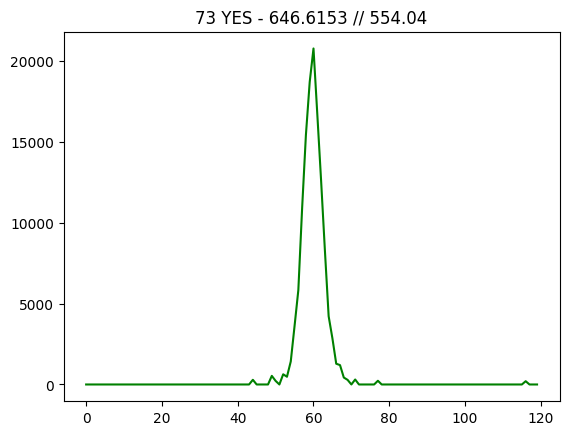

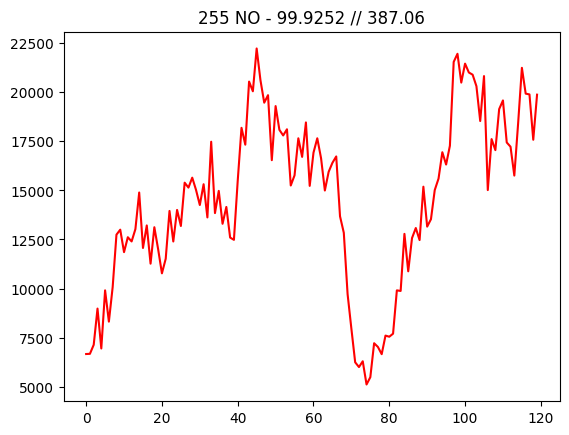

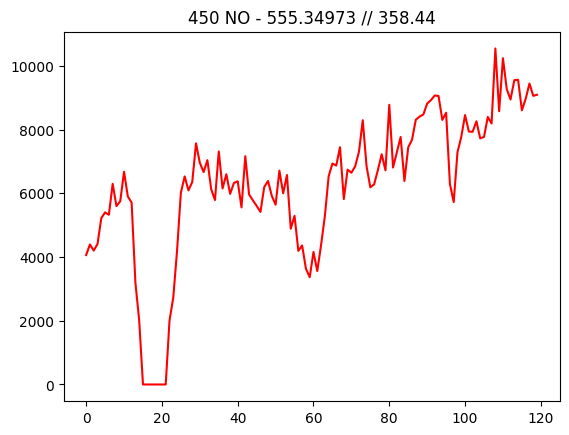

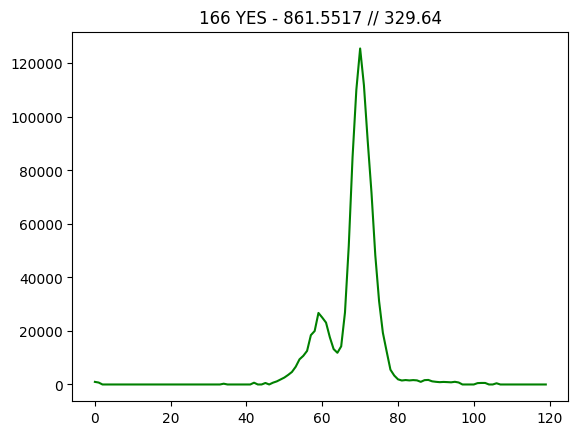

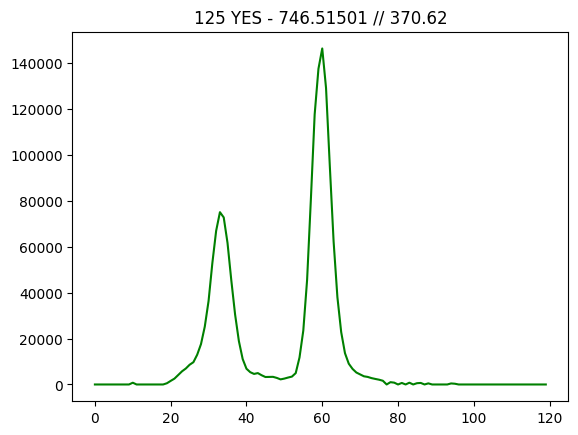

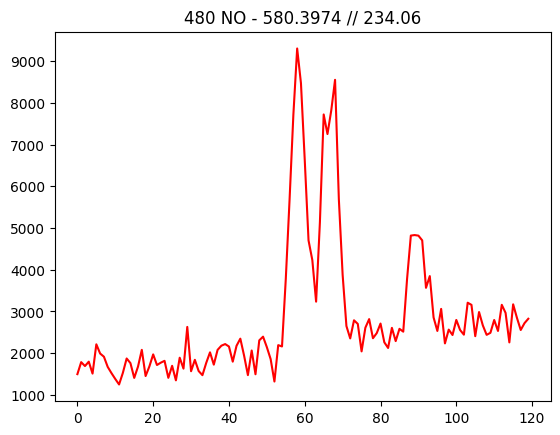

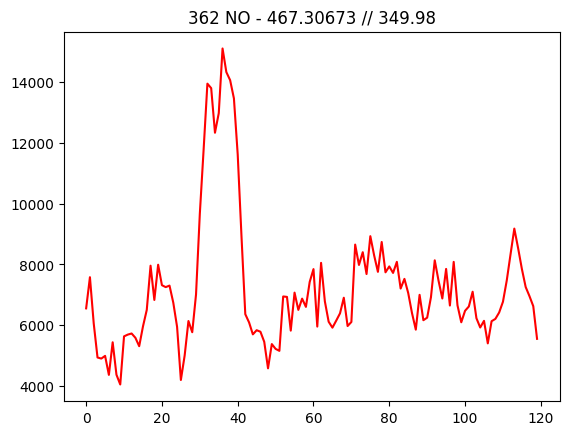

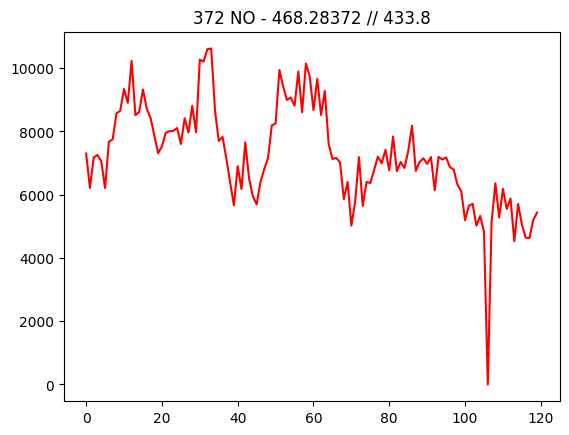

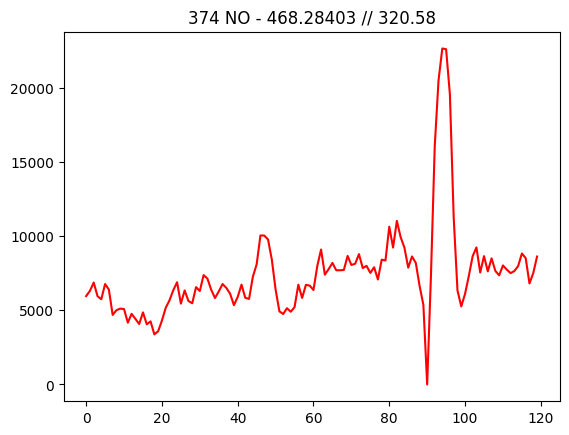

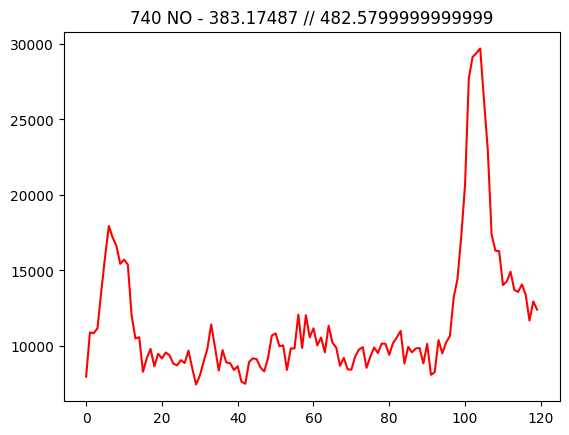

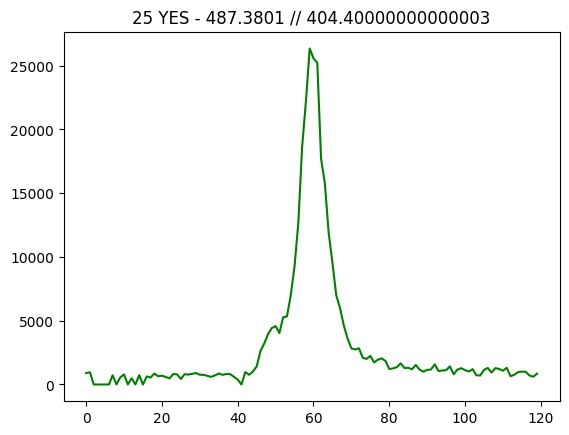

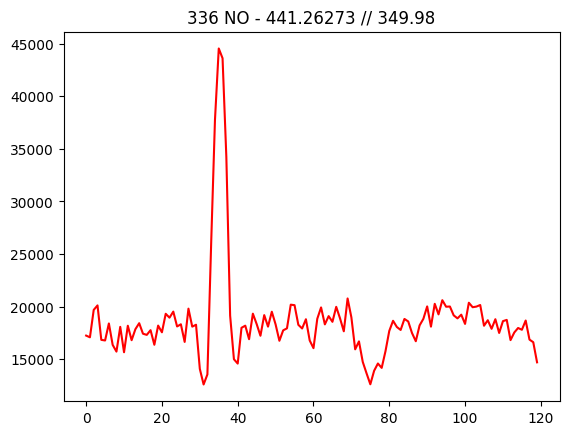

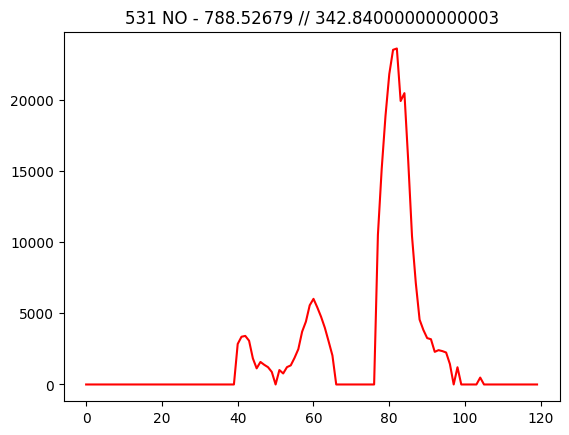

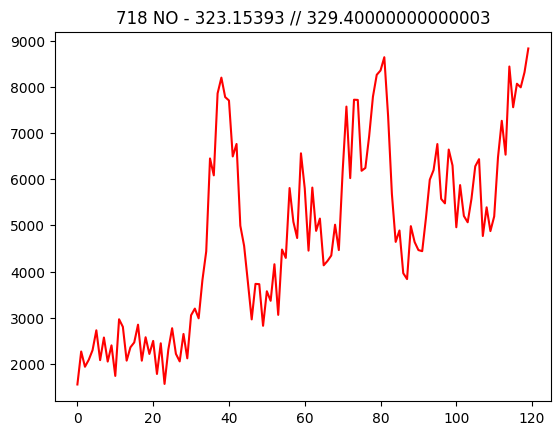

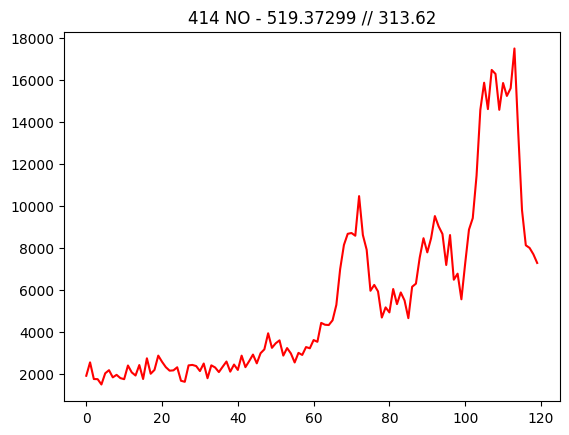

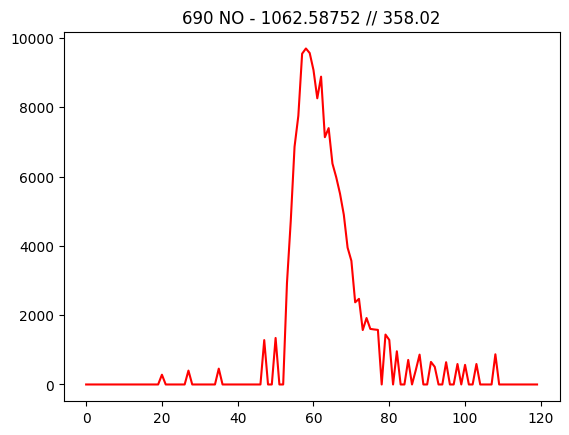

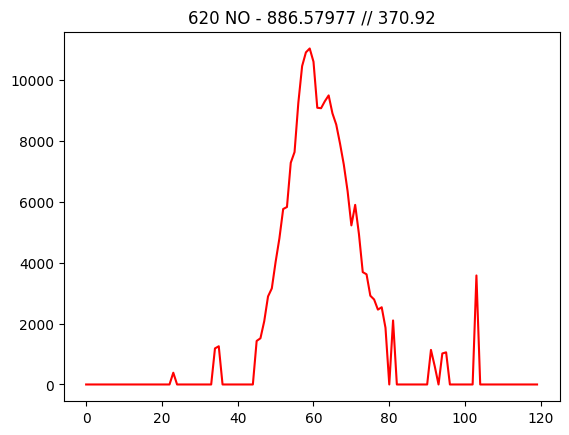

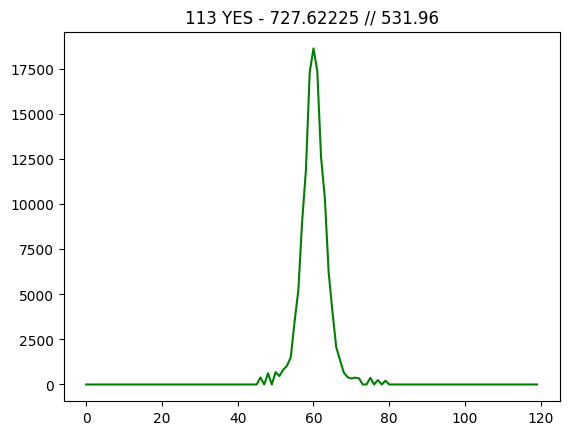

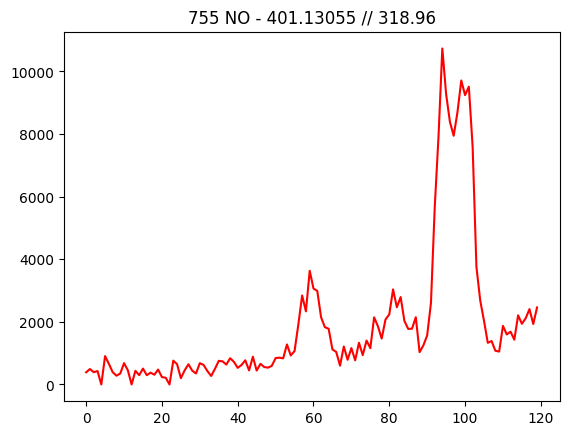

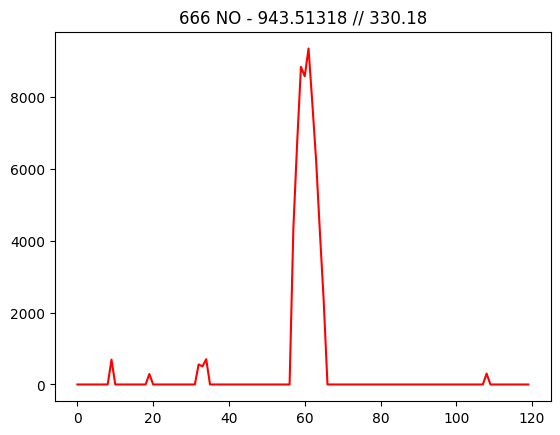

In [17]:


X_ = data[0]
y_ =  data[1]
mz_ = data[2]
rt_ =  data[3]

import random
for i in random.sample(range(0,len(X_)),20):
    color = 'green' if y_[i] == 1 else 'red'
    yn = 'YES' if y_[i] == 1 else 'NO'
    plt.title(  str(i) + ' ' + yn + ' - ' + str(mz_[i]) + ' // ' + str(float(rt_[i])))
    plt.plot(X_[i], color=color)
    plt.show()


In [18]:

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """


    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def NormalizeData(data):
    if np.max(data) - np.min(data) == 0.0:
        return data
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def getStat(data):
    s = [0, 0, 0, 0, 0]  # nbrObs, mean, var,skew, kurtosis

    if len(data) > 0:
        de = scipy.stats.describe(data)
        s = [de[0]/number_sample, de[2], de[3], de[4], de[5]]

    return np.nan_to_num(np.array(s))


def filter_threshold(values):
    if max(values) >= intensity_treshold:
        return True
    return False



In [19]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
augmentx = 10
my_augmenter = (
     #TimeWarp(n_speed_change=2) * augmentx  # random time warping 5 times in parallel
    #Drift(max_drift=(0.1, 0.5))* augmentx # @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     Reverse(prob=.5) * augmentx  # with 50% probability, reverse the sequence
 )


In [20]:
import copy 
xvec =[]
yvec = []
df = pd.DataFrame(X_)
df['y']= y_
df['mz']= mz_
df['rt']= rt_
print(df)

aug = copy.deepcopy(df)
aug[0] = aug[0].map(np.flip)
df = pd. concat([df,aug])
print(df)

                                                     0  y         mz      rt
0    [336.5926, 283.93384, 403.32465, 299.2551, 385...  1  227.20152  149.76
1    [0, 0, 0, 0, 0, 486.59613, 323.1664, 0, 0, 0, ...  1  234.09196   69.12
2    [0, 0, 0, 0, 0, 486.59613, 323.1664, 0, 0, 0, ...  1  234.09196   69.12
3    [552.9305, 517.5925, 376.79205, 246.46094, 377...  1  279.23325  178.68
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  1  299.20129  117.42
..                                                 ... ..        ...     ...
797  [7174.128, 7633.094, 7796.5884, 9442.679, 9524...  0  443.25989  359.22
798  [9330.568, 9545.326, 9141.901, 10190.719, 1108...  0  443.26035   456.9
799  [9056.893, 6974.968, 8470.157, 6691.1694, 7675...  0  443.26047   481.8
800  [5724.94, 5049.97, 5829.6304, 5672.0205, 5941....  0  443.26065   316.5
801  [5967.348, 6016.7505, 6635.265, 6690.4106, 611...  0  443.26071  249.24

[802 rows x 4 columns]
                                                    

In [21]:
df = pd.DataFrame.rename(df, columns = {0:'x'})


In [22]:


df = df[df['x'].map(lambda  x: filter_threshold(x))]
df['y'] = df['y'].apply(lambda x: 1 if x == True else 0)

df['norm'] = df['x'].apply(lambda x: NormalizeData(x) )



df['smooth'] = df['norm'].apply(lambda x: smooth(x) )
df['smooth'] = df['smooth'].apply(lambda x: x[5:-5] )

df['grad1'] = df['smooth'].apply(lambda x: np.gradient(x) )
df['grad2'] = df['grad1'].apply(lambda x: np.gradient(x) )


# Maxima & Minima
df['maxima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(x, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )
df['minima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(-x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )

df['maxval'] =  df[['smooth', 'maxima']].apply(lambda x: [x.smooth[i] for i in x.maxima], axis=1)
df['minval'] =  df[['smooth', 'minima']].apply(lambda x: [x.smooth[i] for i in x.minima], axis=1)

df['maxvalnorm'] =  df['maxval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )
df['minvalnorm'] =  df['minval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )

# Stats
df['maxvalstats'] =  df['maxvalnorm'].apply(lambda x: getStat(x) )
df['minvalstats'] =  df['minvalnorm'].apply(lambda x: getStat(x) )

df['maximastats'] =  df['maxima'].apply(lambda x: getStat(x) )
df['minimastats'] =  df['minima'].apply(lambda x: getStat(x) )

df['stats'] =  df['smooth'].apply(lambda x: getStat(x) )

df['fft'] = df['x'].apply(lambda x: np.fft.fft(x) )
df['fftr'] = df['fft'].apply(lambda x: np.real(x) )
df['ffti'] = df['fft'].apply(lambda x: np.real(np.imag(x)) )

/var/folders/wn/7gdt_pjn02j1w8_73ql8mp880000gn/T/ipykernel_36391/1275335381.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  de = scipy.stats.describe(data)
/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1556: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)
/var/folders/wn/7gdt_pjn02j1w8_73ql8mp880000gn/T/ipykernel_36391/1275335381.py:59: R

In [23]:
df

,x,y,mz,rt,norm,smooth,grad1,grad2,maxima,minima,...,maxvalnorm,minvalnorm,maxvalstats,minvalstats,maximastats,minimastats,stats,fft,fftr,ffti
0,"[336.5926, 283.93384, 403.32465, 299.2551, 385...",1,227.20152,149.76,"[0.014256628321761337, 0.01202622788215508, 0....","[0.014049575036612307, 0.014233228558083547, 0...","[0.0001836535214712401, 0.0003670237425255135,...","[0.00018337022105427338, 0.0002785671943143501...","[12, 21, 34, 48, 60, 75, 80, 99, 113]","[17, 24, 40, 52, 71, 77, 86, 109, 116]",...,"[0.009041018380494568, 0.0, 0.0118657994399221...","[0.0, 0.07130563339608899, 0.12226632063729993...","[0.075, 0.12377571333249243, 0.108062234339853...","[0.075, 0.45378925282526716, 0.178413116845991...","[0.075, 60.22222222222222, 1199.9444444444443,...","[0.075, 65.77777777777777, 1241.4444444444446,...","[1.0, 0.057609009338673654, 0.0158363559677229...","[(163234.07614135742+0j), (-103123.83857332752...","[163234.07614135742, -103123.83857332752, 1040...","[0.0, 4819.770057086, 2699.588137396881, 6373...."
1,"[0, 0, 0, 0, 0, 486.59613, 323.1664, 0, 0, 0, ...",1,234.09196,69.12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01379996915550048,...","[0.0, 0.0002635559586850501, 0.001128591635842...","[0.0002635559586850501, 0.0005642958179214908,...","[0.0003007398592364407, 0.0004122655369021256,...","[12, 20, 35, 46, 60]","[15, 29, 40, 50]",...,"[0.016185165569099404, 0.028565496494684765, 0...","[1.0, 0.0, 0.0, 0.01674268845953159]","[0.041666666666666664, 0.2089842778388377, 0.1...","[0.03333333333333333, 0.2541856721148829, 0.24...","[0.041666666666666664, 34.6, 374.7999999999999...","[0.03333333333333333, 33.5, 225.66666666666666...","[1.0, 0.03529103795328609, 0.01419895931221789...","[(149326.26858520508+0j), (-136011.59543336305...","[149326.26858520508, -136011.59543336305, 1381...","[0.0, -4559.898791020763, -8347.080872501065, ..."
2,"[0, 0, 0, 0, 0, 486.59613, 323.1664, 0, 0, 0, ...",1,234.09196,69.12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01379996915550048,...","[0.0, 0.0002635559586850501, 0.001128591635842...","[0.0002635559586850501, 0.0005642958179214908,...","[0.0003007398592364407, 0.0004122655369021256,...","[12, 20, 35, 46, 60]","[15, 29, 40, 50]",...,"[0.016185165569099404, 0.028565496494684765, 0...","[1.0, 0.0, 0.0, 0.01674268845953159]","[0.041666666666666664, 0.2089842778388377, 0.1...","[0.03333333333333333, 0.2541856721148829, 0.24...","[0.041666666666666664, 34.6, 374.7999999999999...","[0.03333333333333333, 33.5, 225.66666666666666...","[1.0, 0.03529103795328609, 0.01419895931221789...","[(149326.26858520508+0j), (-136011.59543336305...","[149326.26858520508, -136011.59543336305, 1381...","[0.0, -4559.898791020763, -8347.080872501065, ..."
3,"[552.9305, 517.5925, 376.79205, 246.46094, 377...",1,279.23325,178.68,"[0.0016324738, 0.0014642488, 0.0007939731, 0.0...","[0.0011184840028161695, 0.0010681741749058065,...","[-5.0309827910362996e-05, -9.6086682607683e-05...","[-4.577685469732e-05, -4.7853082154486546e-05,...","[16, 26, 34, 43, 59, 69, 77, 94, 111]","[4, 22, 30, 37, 46, 67, 74, 90, 106, 115]",...,"[0.0004894419622811248, 0.00013434948301060625...","[0.0, 0.012887667096167154, 0.0105492320642029...","[0.075, 0.12452373057774849, 0.108307104772450...","[0.08333333333333333, 0.21215612438772546, 0.1...","[0.075, 58.77777777777778, 1021.4444444444443,...","[0.08333333333333333, 59.1, 1386.9888888888888...","[1.0, 0.03781282017927137, 0.01298463430355679...","[(978711.756439209+0j), (-861063.6427803086+58...","[978711.756439209, -861063.6427803086, 796048....","[0.0, 58582.54318140487, -37985.10403171393, 6..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,299.20129,117.42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[60, 76, 102]","[72, 91]",...,"[1.0, 0.0, 0.000524350065273028]","[1.0, 0.0]","[0.025, 0.33350811668842434, 0.333158641625905...","[0.

In [24]:
def ret_mats(df):
    xfft = np.hstack([np.vstack(df['fftr']), np.vstack(df['ffti']),
                      np.vstack(df['maxvalstats']),
                  np.vstack(df['minvalstats']),
                  np.vstack(df['maximastats']),
                  np.vstack(df['minimastats']),
                  np.vstack(df['stats'])
                  ])

    xstat = np.hstack([np.vstack(df['maxvalstats']),
                       np.vstack(df['minvalstats']),
                  np.vstack(df['maximastats']),
                  np.vstack(df['minimastats']),
                  np.vstack(df['stats'])
                  ])

    x = np.stack([ np.vstack(df['norm']), np.vstack(df['smooth']) ,
              np.vstack(df['grad1']) , np.vstack(df['grad2'])  ] , axis = 2)
    y = df.y.map(lambda x : float(x))

    return x,xfft,xstat, y


train, test = train_test_split(df, test_size=0.1, random_state=42)

mats={'train':ret_mats(train), 'test':ret_mats(test)}

In [ ]:
model = None
tf.config.run_functions_eagerly(True)
inputvec = Input(shape=(120,4))
inputfft = Input(shape=(265))
inputstat = Input(shape=(25))
lstm = LSTM(150,  return_sequences = True , return_state = False, dropout=0.4,
    recurrent_dropout=0, go_backwards=True)

whole_seq_output = lstm(inputvec)
lstm2 = LSTM(50, return_sequences = True , return_state = False, dropout=0,
    recurrent_dropout=0, go_backwards=True )

whole_seq_output2 = lstm2(whole_seq_output)

lstm3 = LSTM(20, return_sequences = False , return_state = True, dropout=0,
    recurrent_dropout=0, go_backwards=True )
final_memory_state, final_carry_state, whole_seq_output = lstm3(whole_seq_output2)
aux_input = tf.keras.layers.Concatenate()([final_memory_state, final_carry_state])
output1 = Dense(100,activation = 'tanh')(aux_input)
aux = Dense(1,activation = 'tanh' , name = 'AuxRnnOut' )(output1)


dense_input = tf.keras.layers.Concatenate()([final_memory_state, final_carry_state, inputfft,inputstat])

output1 = tf.keras.layers.Dropout(0.5)(dense_input)
output1 = Dense(500,activation = 'tanh')(dense_input)
output1 = tf.keras.layers.Dropout(0.5)(output1)
output1 = Dense(200,activation = 'tanh')(dense_input)
output1 = tf.keras.layers.Dropout(0.25)(output1)
output1 = Dense(100,activation = 'tanh')(output1)
output1 = Dense(50,activation = 'tanh')(output1)
#output = tf.keras.layers.Dropout(0.1)(output1)
final = Dense(1,activation = 'tanh' , name = 'GlobalOut' )(output1)
model = Model( inputs = [inputvec,inputfft,inputstat ] , outputs = [final,aux])
opt = tf.keras.optimizers.Nadam( learning_rate=0.001)
#opt = tf.keras.optimizers.RMSprop( learning_rate=0.01)
#model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit([mats['train'][0], mats['train'][1], mats['train'][2]],  [mats['train'][3],mats['train'][3]] , validation_data= ( [ mats['test'][0], mats['test'][1], mats['test'][2]] , [mats['test'][3],mats['test'][3]] )  , shuffle = True, epochs=400, batch_size=1000 , verbose= 0)

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(history.history['GlobalOut_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


In [ ]:
scores = model.evaluate([ mats['test'][0], mats['test'][1], mats['test'][2]], mats['test'][3], verbose=1)
print(scores)

In [ ]:
model.save('output/model_peak_' + str(int(time.time())))

In [12]:
new_model = tf.keras.models.load_model('output/model_peak_1665060139/')
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 4)]     0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 120, 150)     93000       ['input_4[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  (None, 120, 50)      40200       ['lstm_3[0][0]']                 
                                                                                                  
 lstm_5 (LSTM)                  [(None, 20),         5680        ['lstm_4[0][0]']                 
                                 (None, 20),                                                

In [13]:
scores = new_model.evaluate([mats['test'][0], mats['test'][1], mats['test'][2]], mats['test'][3], verbose=1)
print(scores)

2022-10-06 15:45:00.871207: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 1s 30ms/step - loss: 0.1558 - GlobalOut_loss: 0.0626 - AuxRnnOut_loss: 0.0932 - GlobalOut_accuracy: 0.9193 - AuxRnnOut_accuracy: 0.8696
[0.1557648926973343, 0.06255697458982468, 0.09320791810750961, 0.9192546606063843, 0.8695651888847351]


6/6 [==============================] - 1s 29ms/step


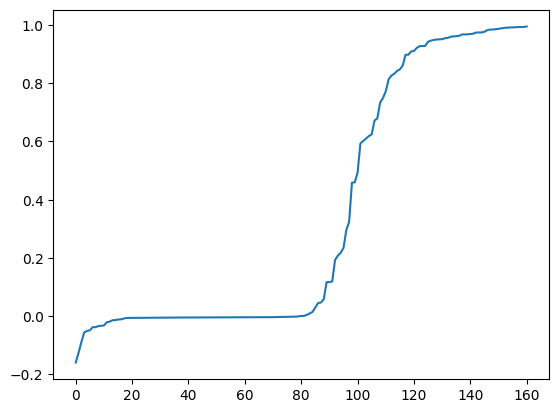

In [25]:


pre_raw = new_model.predict([mats['test'][0], mats['test'][1], mats['test'][2]])
plt.plot(sorted(pre_raw[0]))
plt.show()

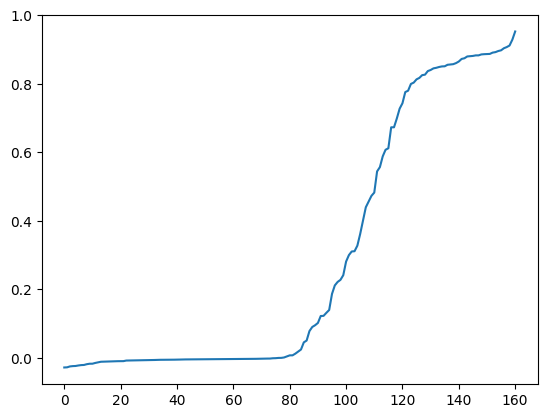

In [26]:
plt.plot(sorted(pre_raw[1]))
plt.show()

In [27]:
vis = test.copy().reset_index()
vis['prediction'] = vis.apply(lambda x: pre_raw[1][x.name][0], axis=1)
vis

,index,x,y,mz,rt,norm,smooth,grad1,grad2,maxima,...,minvalnorm,maxvalstats,minvalstats,maximastats,minimastats,stats,fft,fftr,ffti,prediction
0,528,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,786.52893,347.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[68, 111]",...,[0.1323822033956153],"[0.016666666666666666, 0.5, 0.5, 0.0, -2.0]","[0.008333333333333333, 0.1323822033956153, 0.0...","[0.016666666666666666, 89.5, 924.5, 0.0, -2.0]","[0.008333333333333333, 104.0, 0.0, 0.0, 0.0]","[1.0, 0.2725164707334527, 0.08233253008595229,...","[(368663.7565917969+0j), (-193682.5842530886+1...","[368663.7565917969, -193682.5842530886, 90184....","[0.0, 147651.20531843518, -58082.60710189442, ...",-0.024859
1,339,"[9581.0107421875, 11636.306640625, 11157.75097...",0,441.26288,195.84,"[0.6832266496245718, 0.8297908241634231, 0.795...","[0.7744478089000358, 0.7710029143677956, 0.762...","[-0.0034448945322402835, -0.005960571503472067...","[-0.002515676971231784, -0.003265683881226805,...","[13, 35, 43, 58, 76, 94, 108]",...,"[1.0, 0.9251987695550884, 0.9561091414675009, ...","[0.058333333333333334, 0.6341419246289053, 0.1...","[0.058333333333333334, 0.6672210859105114, 0.1...","[0.058333333333333334, 61.0, 1139.333333333333...","[0.058333333333333334, 55.285714285714285, 120...","[1.0, 0.591193686177977, 0.03070519111075016, ...","[(993743.5744628906+0j), (-76614.73232116945-1...","[993743.5744628906, -76614.73232116945, 26436....","[0.0, -145122.59474280797, -81357.23223865329,...",-0.010836
2,168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,861.55334,334.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[24, 32, 50, 60, 92]",...,"[0.0, 0.005065654308855565, 1.0, 0.01487451237...","[0.041666666666666664, 0.24470654511177242, 0....","[0.03333333333333333, 0.25498504167019964, 0.2...","[0.041666666666666664, 51.6, 712.8, 0.55773394...","[0.03333333333333333, 51.0, 755.3333333333333,...","[1.0, 0.06916935793418308, 0.02746949430061403...","[(1041950.8882751465+0j), (-981708.033779129-7...","[1041950.8882751465, -981708.033779129, 838350...","[0.0, -71816.14161141013, 112864.61443973896, ...",0.727275
3,135,"[4692.7573, 4989.7505, 0, 3585.4236, 3183.7576...",1,764.52557,376.98,"[0.04662421714435809, 0.0495749501175244, 0.0,...","[0.033392357971983797, 0.03285958337154945, 0....","[-0.0005327746004343478, -0.001100941679180357...","[-0.0005681670787460093, -0.000931518720638780...","[14, 38, 59, 92]",...,"[0.10105793585966107, 0.0, 1.0, 0.004686058700...","[0.03333333333333333, 0.43232590472404286, 0.2...","[0.03333333333333333, 0.2764359986400315, 0.23...","[0.03333333333333333, 50.75, 1094.25, 0.202514...","[0.03333333333333333, 41.75, 1231.583333333333...","[1.0, 0.10463517338223124, 0.03607161251090735...","[(1264457.5654907227+0j), (-844571.3101859835-...","[1264457.5654907227, -844571.3101859835, 28992...","[0.0, -508840.6643490926, 348167.4309882602, 1...",0.860197
4,786,"[18824.045, 18583.662, 17485.164, 16704.21, 18...",0,441.26276,391.5,"[0.6339721, 0.6157411, 0.532429, 0.4732001, 0....","[0.5767921947105185, 0.5752309519311999, 0.573...","[-0.0015612427793185724, -0.001517224938535843...","[4.4017840782728523e-05, 0.0013617435339121908...","[10, 18, 54, 81, 96, 107, 117]",...,"[0.841924766975006, 1.0, 0.44990761473166413, ...","[0.058333333333333334, 0.53523913868623, 0.090...","[0.058333333333333334, 0.6257961577048984, 0.1...","[0.058333333333333334, 69.0, 1821.333333333333...","[0.058333333333333334, 60.42857142857143, 1871...","[1.0, 0.5663988633350485, 0.02866487702150742,...","[(2151570.4091796875+0j), (79124.54294727858-1...","[2151570.4091796875, 79124.54294727858, -21336...","[0.0, -13893.39